# Automated Tuning
Instead of manually adjusting hyperparameters, we can use different approaches to automatically  find the best combination.

 ## Hyperparameter Tuning by Grid-Search

In [1]:
import pandas as pd
from sklearn.externals.array_api_compat.torch import remainder

adult_census = pd.read_csv("../1 Predictive Modeling Pipeline/adult.csv")

target_name = "class"
target = adult_census[target_name]

data = adult_census.drop(columns=[target_name, "education-num"])

In [2]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    data,
    target,
    random_state=42
)

In [3]:
from sklearn.compose import make_column_selector as selector

categorical_selector = selector(dtype_include=object)
categorical_columns = categorical_selector(data)

In this example, we wil use a tree-based model as a classifier: `HistGradientBoostingClassifier`. This means numerical variables do not need scaling and categorical variables can be dealt with using an `OrdinalEncoder`.

In [4]:
from sklearn.preprocessing import OrdinalEncoder

categorical_preprocessor = OrdinalEncoder(
    handle_unknown="use_encoded_value",
    unknown_value=-1
)

In [5]:
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ("categorical_preprocessor", categorical_preprocessor, categorical_columns)
    ],
    remainder="passthrough"
)

In [6]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.pipeline import Pipeline

model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", HistGradientBoostingClassifier(
            random_state=42,
            max_leaf_nodes=4
        ))
    ]
)

`GridSearchCV` is an estimator allows us to find the best combination of hyperparameters over a *fixed grid* of values. It is computationally costly, so we only explore the combination of `learning_rate` and `max_leaf_nodes`.

It works by creating combinations of the parameters we provide and running on them. Once the grid-search is fitted, it can be used as any other predictor by calling `predict` or `score`, which internally uses the best model with the parameters found during `fit`.

In [7]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "classifier__learning_rate": [0.01, 0.1, 1.0, 10.0],
    "classifier__max_leaf_nodes": [3, 10, 30],
}
model_grid_search = GridSearchCV(
    model,
    param_grid=param_grid,
    n_jobs=2,
    cv=2
)
model_grid_search.fit(X_train, y_train)

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...m_state=42))])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'classifier__learning_rate': [0.01, 0.1, ...], 'classifier__max_leaf_nodes': [3, 10, ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",None
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",2
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",2
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is displayed;- >2 : th

In [8]:
accuracy = model_grid_search.score(X_test, y_test)
accuracy

0.8793710588813365

**Note:** typically, we use `GridSearchCV` as part of a pipeline that we run `cross_validate` on.

In [9]:
cv_results = pd.DataFrame(model_grid_search.cv_results_).sort_values(
    "mean_test_score", ascending=False
)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__learning_rate,param_classifier__max_leaf_nodes,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
5,0.463375,0.010945,0.087720,0.001824,0.10,30,"{'classifier__learning_rate': 0.1, 'classifier...",0.867165,0.866175,0.866670,0.000495,1
4,0.258802,0.000846,0.055444,0.000586,0.10,10,"{'classifier__learning_rate': 0.1, 'classifier...",0.865746,0.866175,0.865961,0.000215,2
6,0.089114,0.001098,0.034878,0.000170,1.00,3,"{'classifier__learning_rate': 1.0, 'classifier...",0.860559,0.861261,0.860910,0.000351,3
7,0.080448,0.001616,0.032159,0.000622,1.00,10,"{'classifier__learning_rate': 1.0, 'classifier...",0.857229,0.853180,0.855205,0.002024,4
3,0.146659,0.003538,0.049574,0.002916,0.10,3,"{'classifier__learning_rate': 0.1, 'classifier...",0.852752,0.854272,0.853512,0.000760,5
8,0.112015,0.001575,0.031839,0.000776,1.00,30,"{'classifier__learning_rate': 1.0, 'classifier...",0.848548,0.844827,0.846687,0.001861,6
2,0.581751,0.000367,0.067098,0.002617,0.01,30,"{'classifier__learning_rate': 0.01, 'classifie...",0.843252,0.847666,0.845459,0.002207,7
1,0.241326,0.000120,0.053350,0.000973,0.01,10,"{'classifier__learning_rate': 0.01, 'classifie...",0.818956,0.816708,0.817832,0.001124,8
0,0.148333,0.000146,0.044590,0.000906,0.01,3,"{'classifier__learning_rate': 0.01, 'classifie...",0.797882,0.796451,0.797166,0.000715,9
10,0.055376,0.001040,0.029083,0.000864,10.00,10,"{'classifier__learning_rate': 10.0, 'classifie...",0.742356,0.493803,0.618080,0.124277,10


In [10]:
column_results = [f"param_{name}" for name in param_grid.keys()]
column_results += ["mean_test_score", "std_test_score", "rank_test_score"]
cv_results = cv_results[column_results]

In [11]:
def shorten_param(param_name):
    if "__" in param_name:
        return param_name.rsplit("__", 1)[1]
    return param_name


cv_results = cv_results.rename(shorten_param, axis=1)
cv_results

,learning_rate,max_leaf_nodes,mean_test_score,std_test_score,rank_test_score
5,0.10,30,0.866670,0.000495,1
4,0.10,10,0.865961,0.000215,2
6,1.00,3,0.860910,0.000351,3
7,1.00,10,0.855205,0.002024,4
3,0.10,3,0.853512,0.000760,5
8,1.00,30,0.846687,0.001861,6
2,0.01,30,0.845459,0.002207,7
1,0.01,10,0.817832,0.001124,8
0,0.01,3,0.797166,0.000715,9
10,10.00,10,0.618080,0.124277,10


To visualize the grid-search as a heatmap (given there are only 2 parameters we tuned here), we need to transform `cv_results` into a `DataFrame` where the rows correspond to the learning rate and the columns correspond to the maximum number of leaf, and the content is the mean test scores.

In [12]:
pivoted_cv_results = cv_results.pivot_table(
    values="mean_test_score",
    index=["learning_rate"],
    columns=["max_leaf_nodes"],
)

pivoted_cv_results

max_leaf_nodes,3,10,30
learning_rate,,,
0.01,0.797166,0.817832,0.845459
0.10,0.853512,0.865961,0.866670
1.00,0.860910,0.855205,0.846687
10.00,0.283476,0.618080,0.351369


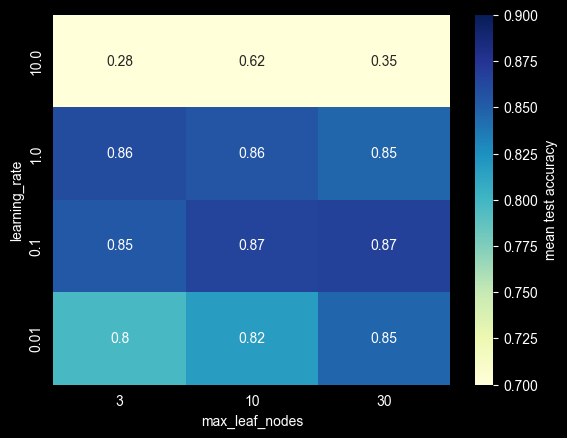

In [13]:
import seaborn as sns

ax = sns.heatmap(
    pivoted_cv_results,
    annot=True,
    cmap="YlGnBu",
    vmin=0.7,
    vmax=0.9,
    cbar_kws={"label": "mean test accuracy"},
)
ax.invert_yaxis()